In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [57]:
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms, datasets
import os
import shutil
import random
import csv
import zipfile
import PIL
import math
from IPython.display import clear_output

In [18]:
class Generator(nn.Module):
    def __init__(self, size_z, num_feature_maps, num_color_channels):
        super(Generator, self).__init__()
        self.size_z = size_z
        self.network = nn.Sequential(
            nn.ConvTranspose2d(self.size_z, num_feature_maps * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(num_feature_maps * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature_maps * 4, num_feature_maps * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature_maps * 2, num_feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature_maps, num_color_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        output = self.network(x)
        return output

    def gen_shifted(self, x, shift):
        shift = torch.unsqueeze(shift, -1)
        shift = torch.unsqueeze(shift, -1)
        return self.forward(x + shift)

In [19]:
class Discriminator(nn.Module):
    def __init__(self, num_feature_maps, num_color_channels):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(num_color_channels, num_feature_maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(num_feature_maps, num_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(num_feature_maps * 2, num_feature_maps * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.fc = nn.Sequential(
            nn.Conv2d(num_feature_maps * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        feature = out
        out = self.fc(out)
        return out.view(-1, 1).squeeze(1), feature

In [73]:
class LatentSpaceMapper:
    def __init__(self, generator: Generator, discriminator: Discriminator, device):
        self.generator: Generator = generator
        self.generator.to(device)
        self.discriminator: Discriminator = discriminator
        self.discriminator.to(device)
        self.device = device

    def map_image_to_point_in_latent_space(self, image: torch.Tensor, size_z=100, max_opt_iterations=50000, opt_threshold=140.0, plateu_threshold=0.5):
        z = torch.randn(1, size_z, 1, 1, device=self.device, requires_grad=True)
        z_optimizer = torch.optim.Adam([z], lr=0.8)
        losses = []
        final_loss = 0
        latest_checkpoint_loss = 0

        for i in range(max_opt_iterations):
            loss = self.__get_anomaly_score(z, image.unsqueeze(0).to(self.device))
            loss.backward()
            z_optimizer.step()
            final_loss = loss.data.item()

            if i == 1:
              latest_checkpoint_loss = loss.data.item()

            if loss.data.item() < opt_threshold:
                print(f"Iteration: {i} -- Reached Defined Optimum -- Final Loss: {loss.data.item()}")
                break

            if i % 10000 == 0 or i == max_opt_iterations-1:
                print(f"Iteration: {i} -- Current Loss: {loss.data.item()}")
                losses.append(loss.data.item())

            if i % 5000 == 0:
              if abs(loss.data.item()-latest_checkpoint_loss) < plateu_threshold:
                print(f"Reached Plateu at Iteration {i} -- Loss: {loss.data.item()}")
                break
              latest_checkpoint_loss = loss.data.item()

        return z, final_loss

    def __get_anomaly_score(self, z, x_query):
        lamda = 0.1
        g_z = self.generator(z.to(self.device))
        _, x_prop = self.discriminator(x_query)
        _, g_z_prop = self.discriminator(g_z)

        loss_r = torch.sum(torch.abs(x_query - g_z))
        loss_d = torch.sum(torch.abs(x_prop - g_z_prop))

        return (1 - lamda) * loss_r + lamda * loss_d

In [21]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset


class AnoMNIST(Dataset):
    def __init__(self, root_dir, transform=None):
        root_dir = os.path.join(root_dir, "AnoMNIST")
        assert os.path.exists(os.path.join(root_dir, "anomnist_dataset.csv")), "Invalid root directory"
        self.root_dir = root_dir
        self.transform = transform
        self.label = pd.read_csv(os.path.join(root_dir, "anomnist_dataset.csv"))

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.label.iloc[idx, 0])
        image_label = {"label": self.label.iloc[idx, 1], "anomaly": self.label.iloc[idx, 2]}
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image, image_label


class AnomalyExtendedMNIST(datasets.MNIST):
    def __getitem__(self, idx):
        return super(AnomalyExtendedMNIST, self).__getitem__(idx)[0], {"label": super(AnomalyExtendedMNIST, self).__getitem__(idx)[1], "anomaly": False}


In [22]:
def generate_augmented_mnist_images(base_folder, num, max_augmentation_thickness=5,
                                    randomize_augmentation_thickness=False, labels=[]):
    assert max_augmentation_thickness <= 7, "max_augmentation_thickness must be smaller than 7"
    os.makedirs(base_folder, exist_ok=True)

    dataset = datasets.MNIST(
        root=base_folder,
        train=True,
        download=True,
    )

    if len(labels) > 0:
        dataset = [d for d in dataset if (d[1] in labels)]
    else:
        dataset = dataset.data

    ano_mnist_drop_folder = os.path.join(base_folder, "AnoMNIST")
    csv_path = os.path.join(ano_mnist_drop_folder, "anomnist_dataset.csv")

    os.makedirs(base_folder, exist_ok=True)
    os.makedirs(ano_mnist_drop_folder, exist_ok=True)

    augmentation_thickness: int = random.randint(1, max_augmentation_thickness)
    for i in range(num):
        random_idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[random_idx]

        augmentation_thickness = random.randint(3,
                                                max_augmentation_thickness) if randomize_augmentation_thickness else augmentation_thickness
        random_idx = random.randint(4, 20)
        for j in range(img.size[0]):
            for k in range(augmentation_thickness):
                img.putpixel((j, random_idx + k + 1), 0)

        img.save(os.path.join(ano_mnist_drop_folder, f"img_aug_{label}_{i}.png"))
        with open(csv_path, 'a', newline='') as file:
            writer = csv.writer(file)
            fields = [f'img_aug_{label}_{i}.png', f"{label}", "True"]
            writer.writerow(fields)


def generate_anomalous_image_files(base_folder, num, labels=[], copy_zip_to=''):
    if os.path.exists(base_folder):
        shutil.rmtree(base_folder)

    ano_mnist_drop_folder = os.path.join(base_folder, "AnoMNIST")
    csv_path = os.path.join(ano_mnist_drop_folder, "anomnist_dataset.csv")

    os.makedirs(base_folder, exist_ok=True)
    os.makedirs(ano_mnist_drop_folder, exist_ok=True)

    with open(csv_path, 'a', newline='') as file:
        writer = csv.writer(file)
        fields = ["filename", "label", "anomaly"]
        writer.writerow(fields)

    generate_augmented_mnist_images(base_folder, num=num, labels=labels)
    if copy_zip_to:
      shutil.make_archive(os.path.join(copy_zip_to, "AnoMNIST"), 'zip', ano_mnist_drop_folder)

def get_ano_mnist_dataset(transform, root_dir, labels=[9], train_size=0.9):
    ano_mnist_dataset = AnoMNIST(
        root_dir=root_dir,
        transform=transform
    )

    mnist_dataset = AnomalyExtendedMNIST(
        root=root_dir,
        train=True,
        transform=transform,
        download=True,
    )

    dat = torch.utils.data.ConcatDataset([ano_mnist_dataset, mnist_dataset])

    if len(labels) > 0:
        dat = [d for d in dat if (d[1]['label'] in labels)]

    absolute_train_size = int(len(dat) * train_size)
    absolute_test_size = len(dat) - absolute_train_size
    return torch.utils.data.random_split(dat, [absolute_train_size, absolute_test_size])

In [ ]:
def load_ano_mnist_from_drive(drop_folder=base_folder):
  with zipfile.ZipFile('/content/drive/MyDrive/Colab/data/AnoMNIST.zip', 'r') as zip_ref:
    zip_ref.extractall(base_folder)

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_color_channels = 1
num_feature_maps_g = 64
num_feature_maps_d = 64
size_z = 100

device

device(type='cpu')

In [28]:
generator = Generator(size_z=size_z,
                      num_feature_maps=num_feature_maps_g,
                      num_color_channels=num_color_channels).to(device)
discriminator = Discriminator(num_feature_maps=num_feature_maps_d,
                              num_color_channels=num_color_channels).to(device)

generator.load_state_dict(torch.load("/content/drive/MyDrive/Colab/saved_models/generator.pkl", map_location=torch.device(device)))
discriminator.load_state_dict(torch.load('/content/drive/MyDrive/Colab/saved_models/discriminator.pkl', map_location=torch.device(device)))

<All keys matched successfully>

In [27]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(.5,), std=(.5,))
])

# generate_anomalous_image_files(base_folder='/content/data', num=2000, labels=[9]) # number of normals is: 5949
load_ano_mnist_from_drive(drop_folder='/content/data')
ano_mnist_dataset, _ = get_ano_mnist_dataset(transform=transform, root_dir='/content/data', labels=[9])

Iteration: 0 -- Current Loss: 397.4893493652344
Iteration: 3859 -- Reached Defined Optimum -- Final Loss: 139.99850463867188
Original Image


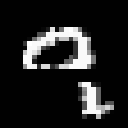

Mapped and Reconstructed Image


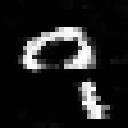

-----------------------
Iteration: 0 -- Current Loss: 472.87890625
Iteration: 10000 -- Current Loss: 229.33079528808594
Iteration: 20000 -- Current Loss: 212.34800720214844
Iteration: 30000 -- Current Loss: 211.41159057617188
Reached Plateu at Iteration 30000 -- Loss: 211.41159057617188
Original Image


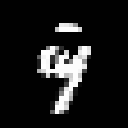

Mapped and Reconstructed Image


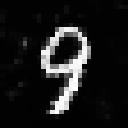

-----------------------
Iteration: 0 -- Current Loss: 435.19610595703125
Iteration: 10000 -- Current Loss: 255.1029510498047
Reached Plateu at Iteration 10000 -- Loss: 255.1029510498047
Original Image


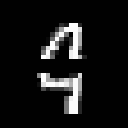

Mapped and Reconstructed Image


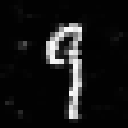

-----------------------
Iteration: 0 -- Current Loss: 442.0037841796875
Iteration: 10000 -- Current Loss: 199.32241821289062
Iteration: 20000 -- Current Loss: 162.33148193359375


In [ ]:
def create_cp(iteration_number):
  print("CREATING CHECKPOINT...")
  drive.mount('/content/drive', force_remount=True)
  shutil.make_archive(f"/content/drive/MyDrive/Colab/data/latent_space_mappings_cp/latent_space_mappings_cp{iteration_number}", 'zip', "/content/data/latent_space_mappings")

def save_to_drive(mapped_z, iteration_number, csv_path):
  torch.save(mapped_z, f'/content/drive/MyDrive/Colab/data/latent_space_mappings/mapped_z_{iteration_number}.pt')
  shutil.copy(csv_path, "/content/drive/MyDrive/Colab/data/latent_space_mappings/latent_space_mappings.csv")

base_folder = "/content/data/latent_space_mappings"
csv_path = os.path.join(base_folder, "latent_space_mappings.csv")

if not os.path.exists(base_folder):
    os.mkdir(base_folder)

if os.path.exists(base_folder):
    shutil.rmtree(base_folder)
    os.mkdir(base_folder)

with open(csv_path, 'a', newline='') as file:
    writer = csv.writer(file)
    fields = ["filename", "label", "anomaly", "reconstruction_loss"]
    writer.writerow(fields)

# Start mapping
only_map_anomalies = True
t = transforms.ToPILImage()
lsm: LatentSpaceMapper = LatentSpaceMapper(generator=generator, discriminator=discriminator, device=device)
mapped_images = []
cp_counter = 0
counter = len(ano_mnist_dataset)
for img in ano_mnist_dataset:

    # print(f"{counter} images left")

    if (img[1]["anomaly"] == True and only_map_anomalies) or not only_map_anomalies:
        mapped_z, reconstruction_loss = lsm.map_image_to_point_in_latent_space(img[0], opt_threshold=140.0)
        mapped_images.append(mapped_z)
        with open(csv_path, 'a', newline='') as file:
            writer = csv.writer(file)
            fields = [f'mapped_z_{counter}.pt', img[1]["label"], img[1]["anomaly"], math.floor(reconstruction_loss)]
            writer.writerow(fields)

        torch.save(mapped_z, f'./latent_space_mappings/mapped_z_{counter}.pt')
        save_to_drive(mapped_z, counter, csv_path)
        cp_counter += 1
        if cp_counter % 50 == 0:
          create_cp(counter)
          clear_output

        print('Original Image')
        t(img[0]).resize((128, 128), PIL.Image.NEAREST).show()
        original_img = generator(mapped_z).cpu()
        img = t(original_img[0]).resize((128, 128), PIL.Image.NEAREST)
        print('Mapped and Reconstructed Image')
        img.show()
        print('-----------------------')

    counter-=1

create_cp(0)

In [ ]:
drive.mount('/content/drive', force_remount=True)

%cd /content/data
base_folder = "/content/drive/MyDrive/Colab/data/latent_space_mappings"

if os.path.exists(base_folder):
    shutil.rmtree(base_folder)
    os.mkdir(base_folder)

!cp -r /content/data/latent_space_mappings /content/drive/MyDrive/Colab/data

Mounted at /content/drive
/content/data


In [ ]:
# img = generator(mapped_z)
# img = tpi(torch.squeeze(img))
# img.show()